In [40]:
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns   
import numpy as np
import tqdm 
import torch
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def extract_features(model, dataloader, device, return_nodes=None, unflatten=True):
    """
    Extracts features from specific layers of a pre-trained model.

    Args:
        model (torch.nn.Module): Pretrained model for feature extraction.
        dataloader (DataLoader): DataLoader to fetch images in batches.
        device (torch.device): Device to run inference on (CPU/GPU).
        return_nodes (dict, optional): Dictionary mapping layer names to output names.
        unflatten (bool, optional): If True, flattens the output features.
    
    Returns:
        dict: Dictionary of extracted features from specified layers.
    """
    # Apply return_nodes if specified
    if return_nodes:
        model = create_feature_extractor(model, return_nodes=return_nodes)

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval() 
    
    # Initialize dictionary to store features for each layer with the key as the layer name
    all_features = {key: [] for key in return_nodes.values()}  


    # Iterate over the dataloader to extract features
    with torch.no_grad():
        for item in tqdm.tqdm(dataloader, total=len(dataloader)):
            imgs, _, _ = item  # Unpack all three returned values
            imgs = imgs.to(device)
            
            batch_activations = model(imgs) 
            for key, activation in batch_activations.items():
                if unflatten:
                    activation = torch.flatten(activation, start_dim=1)  # Flatten while keeping batch dim
                all_features[key].append(activation.detach().cpu())  # Detach and move to CPU for storage
    # Concatenate all batch features for each layer
    all_features = {key: torch.cat(features, dim=0) for key, features in all_features.items()}
    
    return all_features

class COCO_image_dataset(Dataset):
    def __init__(self, root, paths, transform=None, device='cuda'):
        self.paths = paths
        self.transform = transform
        self.root = root

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(self.paths[idx]).convert('RGB')  # Ensure 3 channels

        if self.transform:
            img = self.transform(img)
        return img, 0., idx 

In [3]:
weights = VGG16_Weights.DEFAULT
transform = weights.transforms()

model = vgg16(weights=VGG16_Weights.DEFAULT)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

image_path = "/home/c13745859/Documents/coco_images/val2017"

dataset = COCO_image_dataset(root=image_path,
                             paths=[os.path.join(image_path, f) for f in os.listdir(image_path)],
                             transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
                        

In [33]:
features = extract_features(model, dataloader, device, return_nodes={'features.0': 'conv_1',
                                                                     'features.7': 'conv_4',
                                                                     'features.12': 'conv_6',
                                                                     }, unflatten=False)
print(features['conv_1'].shape)
print(features['conv_4'].shape)
print(features['conv_6'].shape)

100%|██████████| 157/157 [02:17<00:00,  1.14it/s]


torch.Size([5000, 64, 224, 224])
torch.Size([5000, 128, 112, 112])
torch.Size([5000, 256, 56, 56])


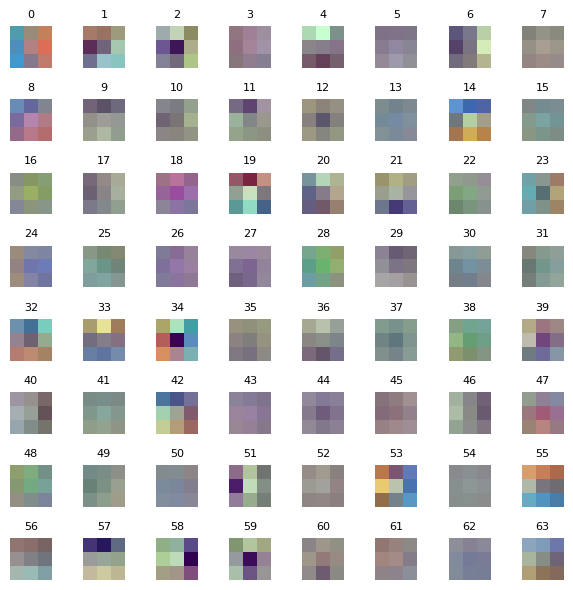

In [5]:
# Get the weights of the first conv layer
filters = model.features[0].weight.data.cpu().numpy()  # Shape: (64, 3, 3, 3)

# Normalize filters for visualization
min_val = filters.min()
max_val = filters.max()
filters = (filters - min_val) / (max_val - min_val)

n_filters = 64  # Total filters in conv1_1
n_rows = 8
n_cols = 8

plt.figure(figsize=(6, 6))
for i in range(n_filters):
    f = filters[i]
    f = np.transpose(f, (1, 2, 0))  # (H, W, C)
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(f)
    plt.axis('off')
    ax.set_title(f'{i}', fontsize=8)
plt.tight_layout()
plt.show()

In [34]:
def get_gram_matrix(activations):
    activations_flattened = activations.flatten(start_dim=-2)
    gram_matrices = torch.matmul(activations_flattened, activations_flattened.transpose(1, 2))  # [N, C, C]
    return gram_matrices

gram_matrices = {key: get_gram_matrix(features[key]) for key in features}

In [37]:
def avg_gram(g_matrices, normalize = False):
    if normalize:
        norms = g_matrices.norm(dim=(1, 2), keepdim=True)  # Shape: [N, 1, 1]
        normalized_gram_matrices = g_matrices / (norms + 1e-8)
        return normalized_gram_matrices.mean(dim=0)
    return g_matrices.mean(dim=0)
avg_gram_matrices = {key: avg_gram(gram_matrices[key], normalize=False) for key in gram_matrices}

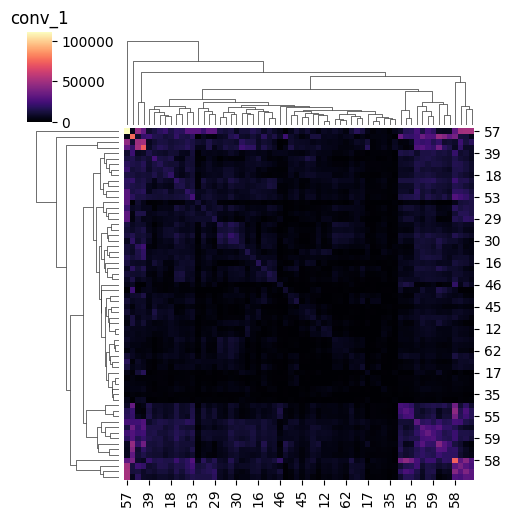

/home/c13745859/anaconda3/envs/BrainAlign_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/c13745859/anaconda3/envs/BrainAlign_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


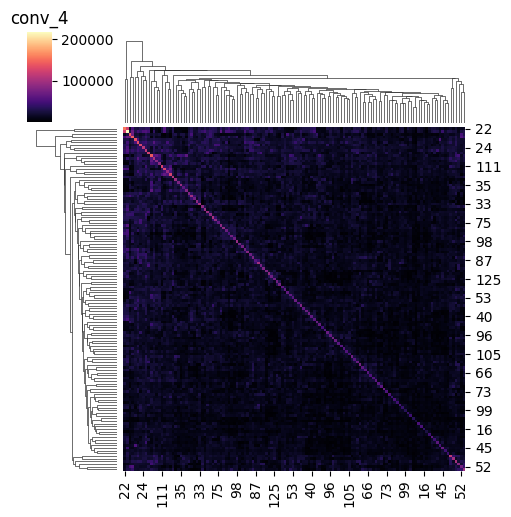

/home/c13745859/anaconda3/envs/BrainAlign_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/c13745859/anaconda3/envs/BrainAlign_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


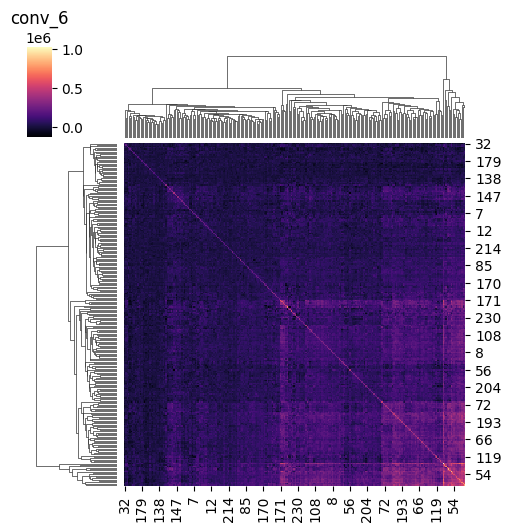

In [39]:
for key in avg_gram_matrices:
    sns.clustermap(avg_gram_matrices[key].numpy(), cmap='magma', figsize=(5,5))
    plt.title(f'{key}')
    plt.show()

In [42]:
N, C, _ = gram_matrices['conv_1'].shape
triu_indices = torch.triu_indices(C, C, offset = 1)  # includes diagonal
# shape: [5000, num_upper_tri]
gram_upper = gram_matrices['conv_1'][:, triu_indices[0], triu_indices[1]]
print(gram_upper.shape)  # (5000, 2080) for C=64

torch.Size([5000, 2016])


In [ ]:
scaler = StandardScaler()
gram_upper_scaled = scaler.fit_transform(gram_upper.numpy())
pca = PCA(n_components=0.8)
gram_pca = pca.fit_transform(gram_upper_scaled)
print(gram_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)

(5000, 8)
Explained variance ratio: [0.24132788 0.19463843 0.10853105 0.09941524 0.06829016 0.04465924
 0.02732997 0.02480082]


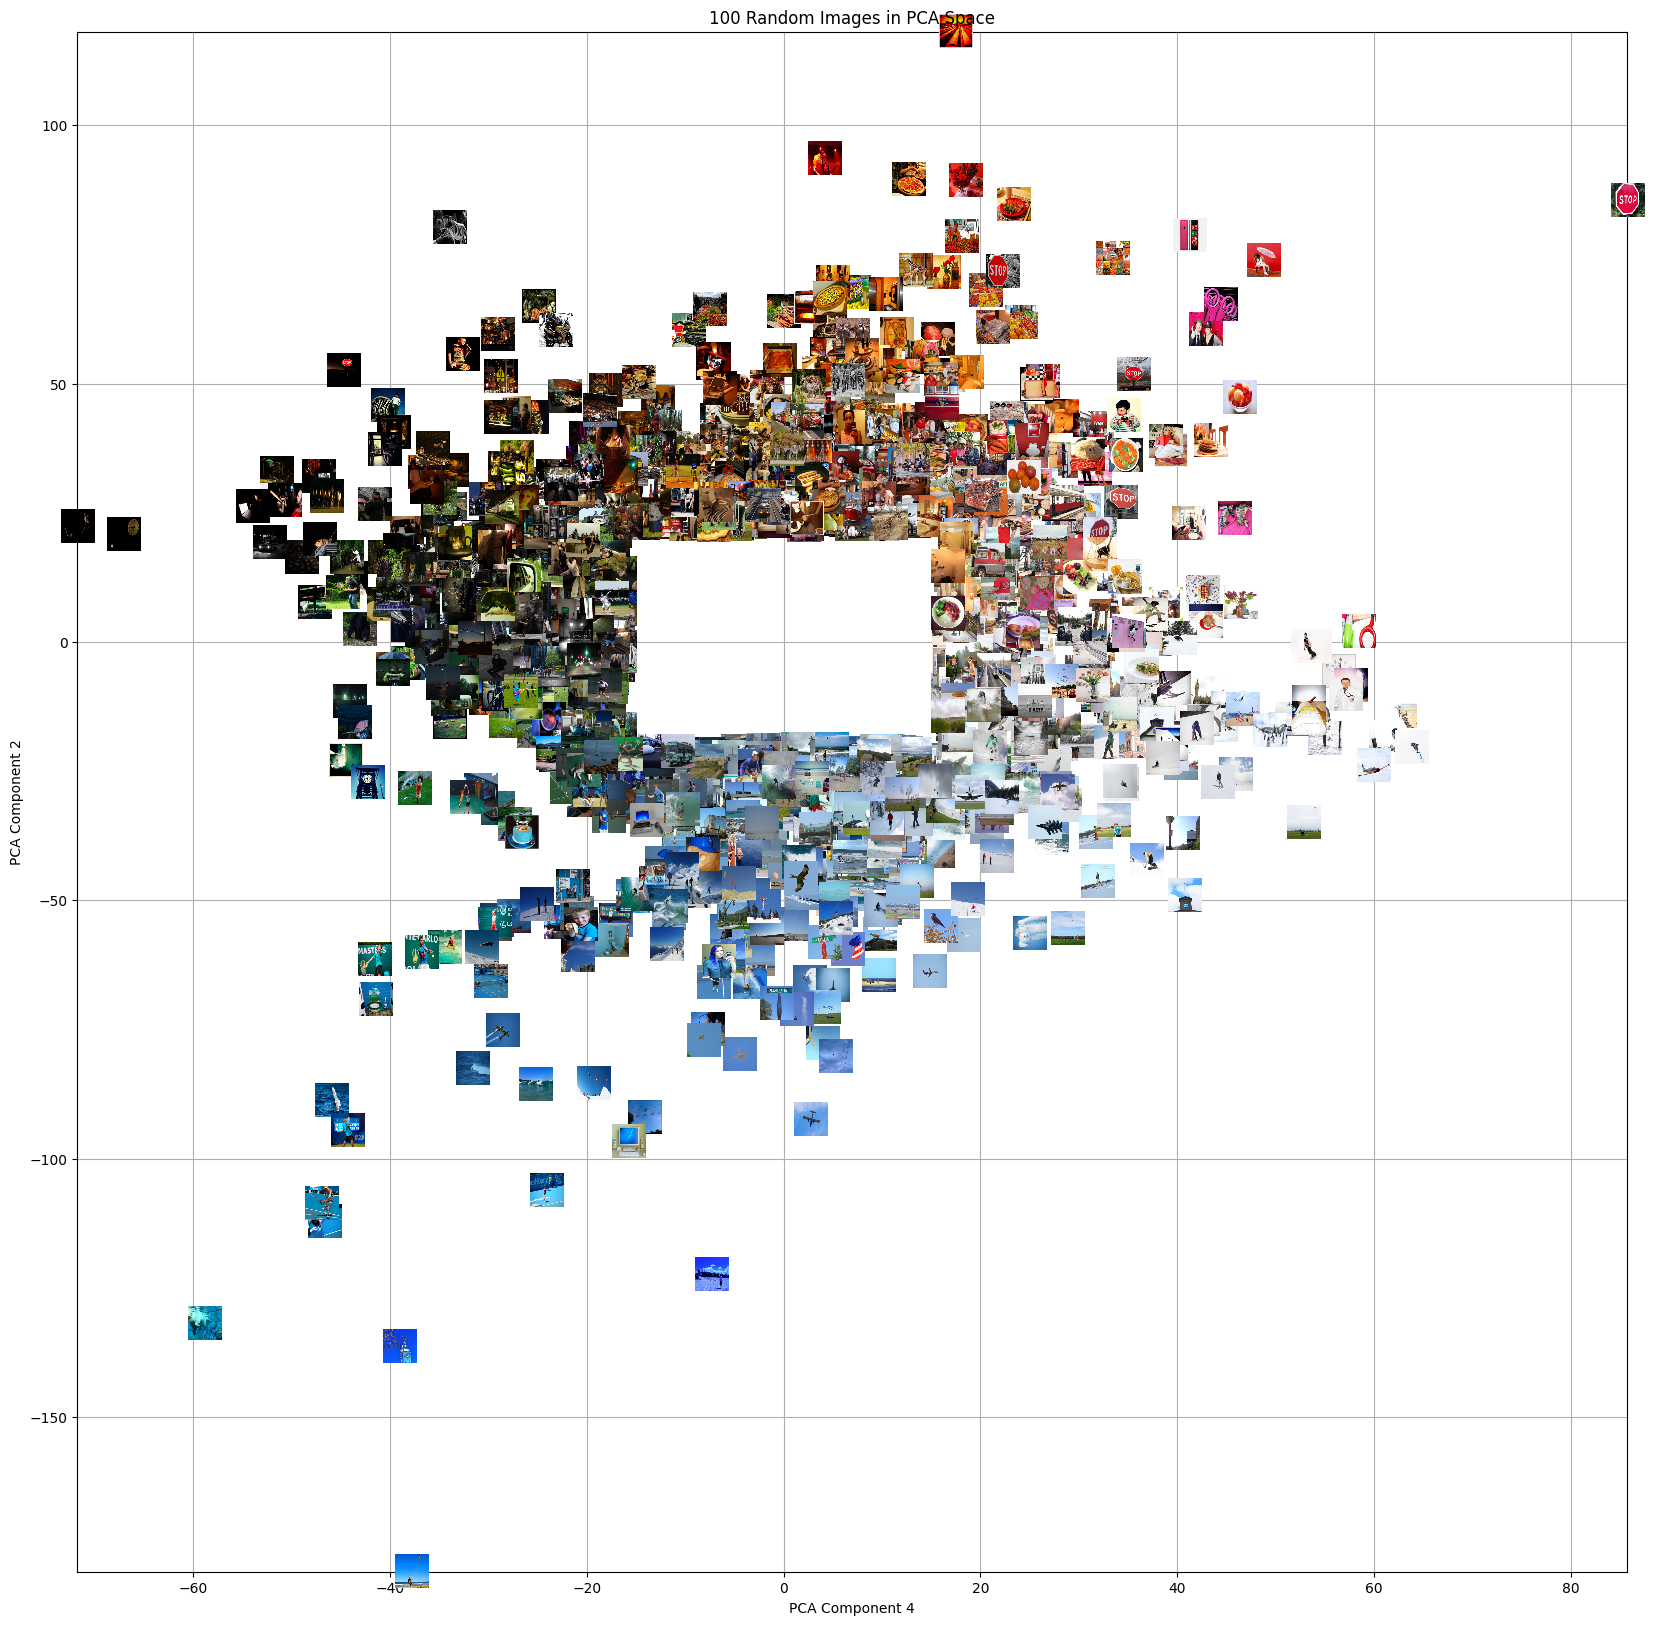

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

target_pcs = [3, 1]

cutoff = 10
percentile_top_pc1 = np.percentile(gram_pca[:, target_pcs[0]], cutoff)
percentile_bottom_pc1 = np.percentile(gram_pca[:, target_pcs[0]], 100- cutoff)
percentile_top_pc2 = np.percentile(gram_pca[:, target_pcs[1]], cutoff)
percentile_bottom_pc2 = np.percentile(gram_pca[:, target_pcs[1]], 100- cutoff)

indices = [
    i for i, point in enumerate(gram_pca)
    if (point[target_pcs[0]] <= percentile_top_pc1 or point[target_pcs[0]] >= percentile_bottom_pc1) or
       (point[target_pcs[1]] <= percentile_top_pc2 or point[target_pcs[1]] >= percentile_bottom_pc2)
]

plt.figure(figsize=(20, 20), dpi=100)
ax = plt.gca()

for idx in indices:
    x, y = gram_pca[idx, target_pcs[0]], gram_pca[idx, target_pcs[1]]
    img = Image.open(dataset.paths[idx]).convert('RGB')
    img = img.resize((128, 128), Image.LANCZOS)  # Resize to higher resolution
    img_np = np.asarray(img)
    imagebox = OffsetImage(img_np, zoom=24/128)  # Display at 24x24 size, but with higher resolution
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.0)
    ax.add_artist(ab)

# Optionally set axis limits to focus on the data
ax.set_xlim(gram_pca[:, target_pcs[0]].min(), gram_pca[:, target_pcs[0]].max())
ax.set_ylim(gram_pca[:, target_pcs[1]].min(), gram_pca[:, target_pcs[1]].max())

plt.xlabel(f'PCA Component {target_pcs[0] + 1}')
plt.ylabel(f'PCA Component {target_pcs[1] + 1}')
plt.title('100 Random Images in PCA Space')
plt.grid(True)
plt.show()

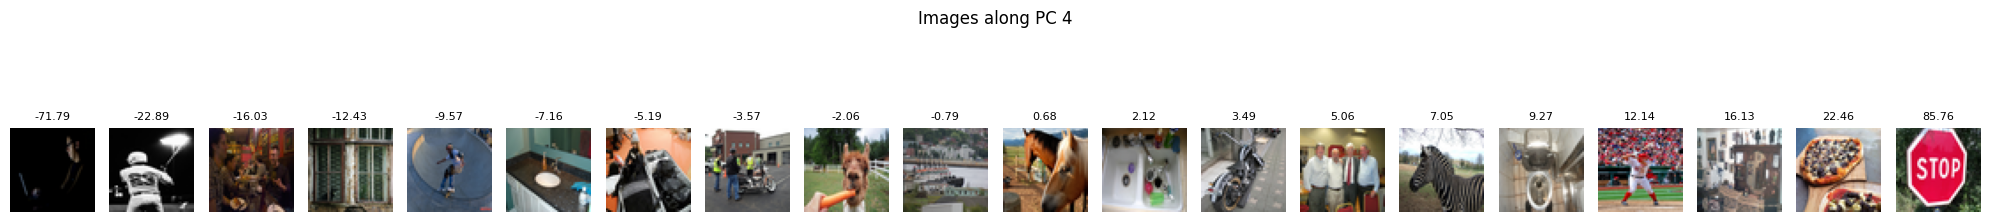

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

pc_idx = 3  # Choose which PC to visualize (e.g., 0 for the first PC)
num_samples = 20  # Number of images to plot

# Sort indices by value along the chosen PC
sorted_indices = np.argsort(gram_pca[:, pc_idx])

# Optionally, sample evenly along the continuum
sampled_indices = np.linspace(0, len(sorted_indices) - 1, num_samples, dtype=int)
selected_indices = [sorted_indices[i] for i in sampled_indices]

plt.figure(figsize=(20, 3))
for i, idx in enumerate(selected_indices):
    img = Image.open(dataset.paths[idx]).convert('RGB')
    img = img.resize((48, 48), Image.LANCZOS)
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{gram_pca[idx, pc_idx]:.2f}", fontsize=8)
plt.suptitle(f'Images along PC {pc_idx + 1}')
plt.tight_layout()
plt.show()

# section

In [23]:
# covariance of the filter responses at conv1_1 for each image across pace
activations_flattened = features['conv1_4'].flatten(start_dim=-2)
gram_matrices = torch.matmul(activations_flattened, activations_flattened.transpose(1, 2))  # [N, C, C]
print(gram_matrices.shape) 

N, C, _ = gram_matrices.shape
triu_indices = torch.triu_indices(C, C, offset = 1)  # includes diagonal
# shape: [5000, num_upper_tri]
gram_upper = gram_matrices[:, triu_indices[0], triu_indices[1]]
print(gram_upper.shape)  # (5000, 2080) for C=64

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gram_upper_scaled = scaler.fit_transform(gram_upper.numpy())
pca = PCA(n_components=0.8)
gram_pca = pca.fit_transform(gram_upper_scaled)
print(gram_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)

torch.Size([5000, 128, 128])
torch.Size([5000, 8128])
(5000, 15)
Explained variance ratio: [0.31707567 0.10692432 0.09718356 0.05834494 0.03965268 0.03478905
 0.02991164 0.0260996  0.02208872 0.0173288  0.01394873 0.01159709
 0.01128446 0.01066034 0.0102017 ]


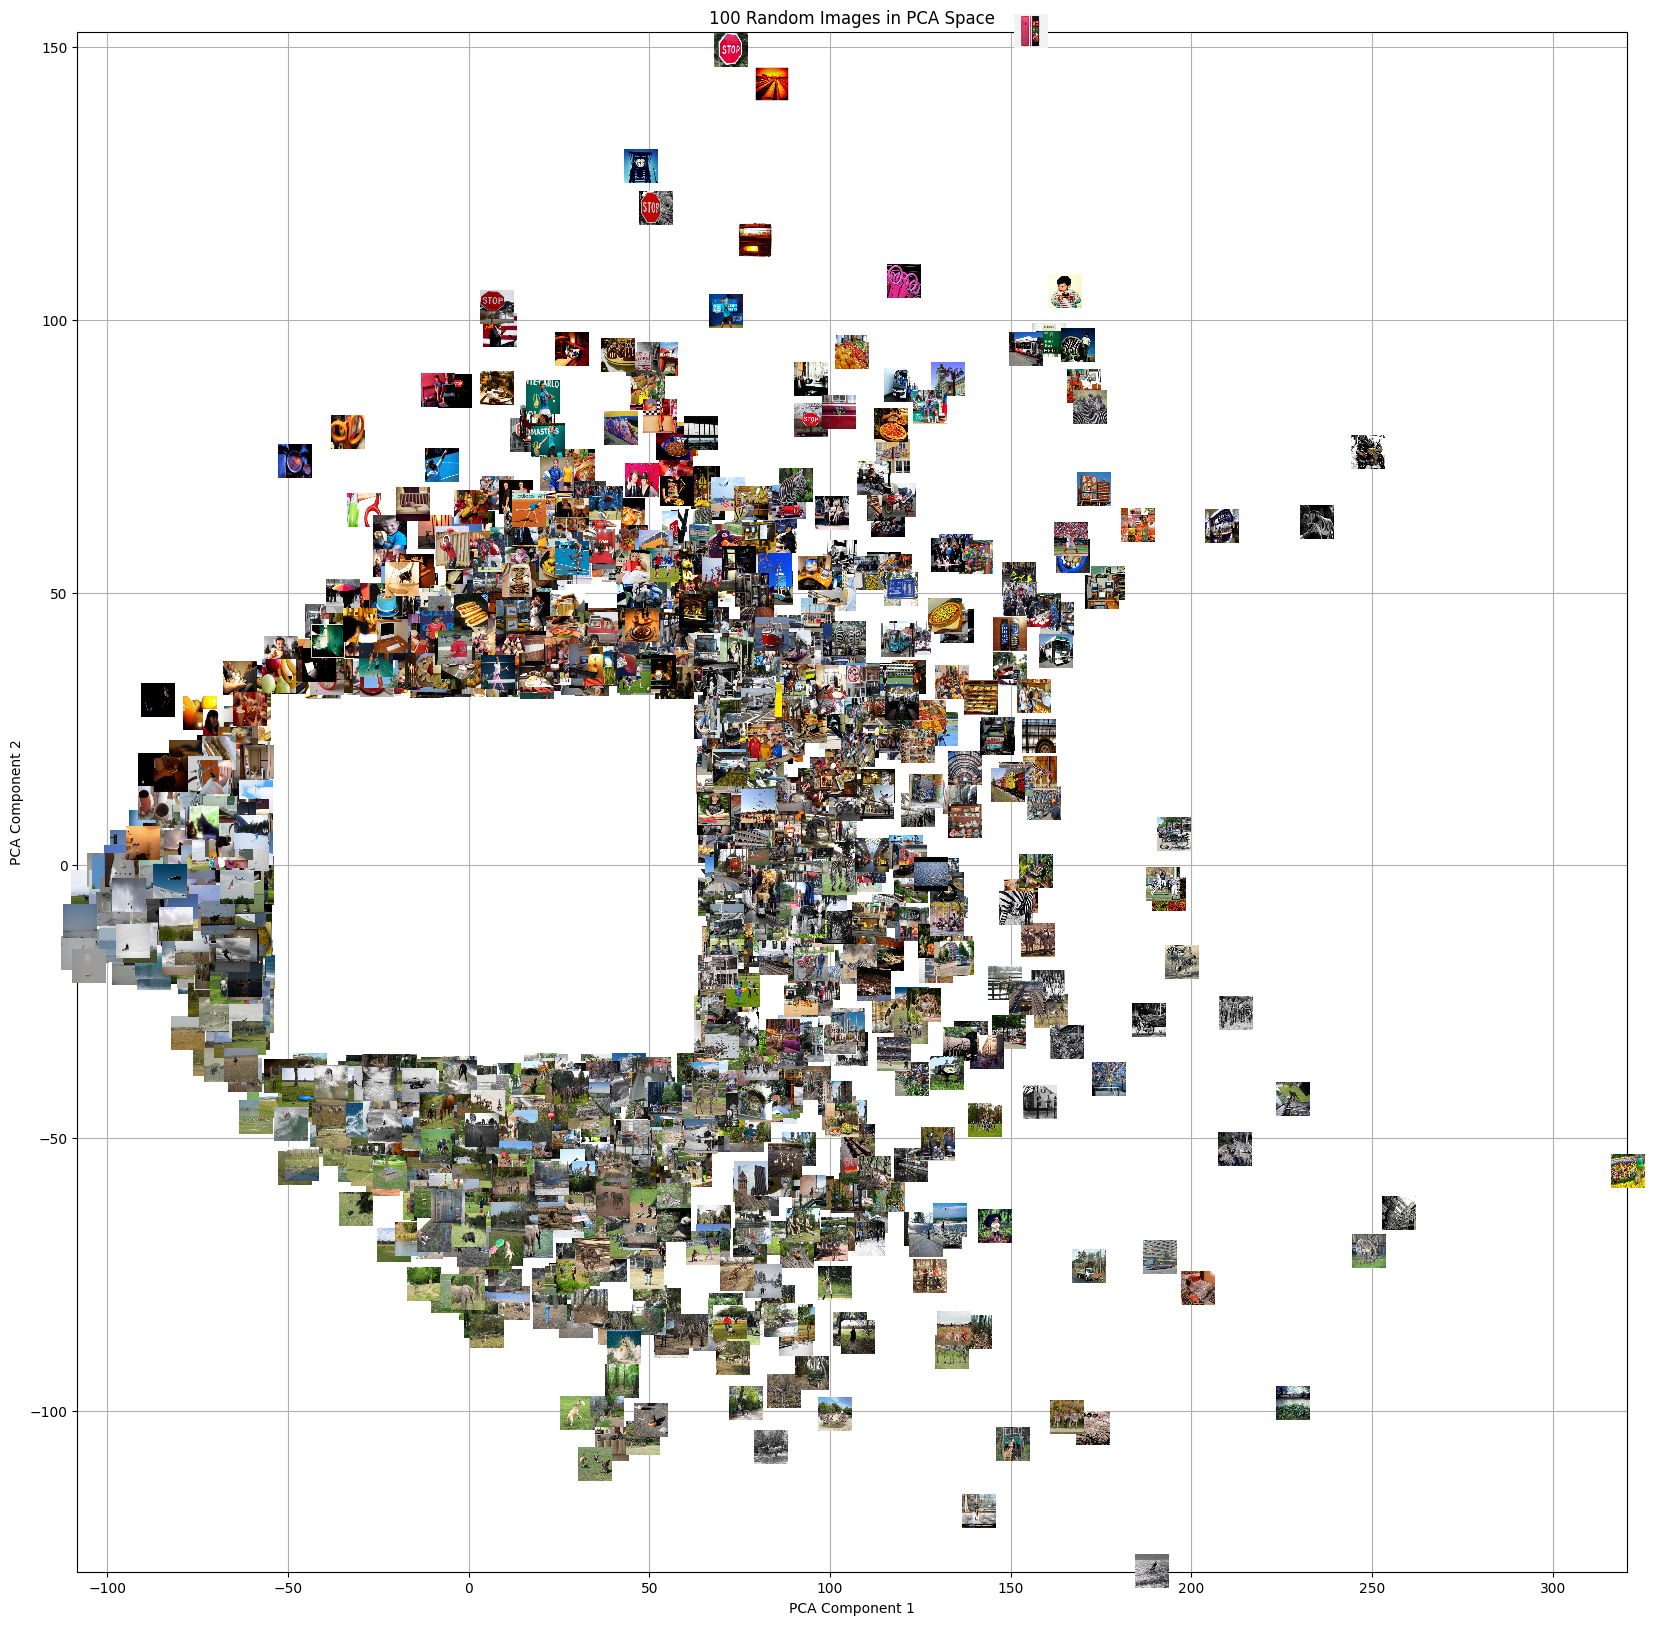

In [ ]:
target_pcs = [0, 1]

cutoff = 10
percentile_top_pc1 = np.percentile(gram_pca[:, target_pcs[0]], cutoff)
percentile_bottom_pc1 = np.percentile(gram_pca[:, target_pcs[0]], 100- cutoff)
percentile_top_pc2 = np.percentile(gram_pca[:, target_pcs[1]], cutoff)
percentile_bottom_pc2 = np.percentile(gram_pca[:, target_pcs[1]], 100- cutoff)

indices = [
    i for i, point in enumerate(gram_pca)
    if (point[target_pcs[0]] <= percentile_top_pc1 or point[target_pcs[0]] >= percentile_bottom_pc1) or
       (point[target_pcs[1]] <= percentile_top_pc2 or point[target_pcs[1]] >= percentile_bottom_pc2)
]

plt.figure(figsize=(20, 20), dpi=100)
ax = plt.gca()

for idx in indices:
    x, y = gram_pca[idx, target_pcs[0]], gram_pca[idx, target_pcs[1]]
    img = Image.open(dataset.paths[idx]).convert('RGB')
    img = img.resize((128, 128), Image.LANCZOS)  # Resize to higher resolution
    img_np = np.asarray(img)
    imagebox = OffsetImage(img_np, zoom=24/128)  # Display at 24x24 size, but with higher resolution
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.0)
    ax.add_artist(ab)

# Optionally set axis limits to focus on the data
ax.set_xlim(gram_pca[:, target_pcs[0]].min(), gram_pca[:, target_pcs[0]].max())
ax.set_ylim(gram_pca[:, target_pcs[1]].min(), gram_pca[:, target_pcs[1]].max())

plt.xlabel(f'PCA Component {target_pcs[0] + 1}')
plt.ylabel(f'PCA Component {target_pcs[1] + 1}')
plt.title('100 Random Images in PCA Space')
plt.grid(True)
plt.show()

In [28]:
# covariance of the filter responses at conv1_1 for each image across pace
activations_flattened = features['conv2_4'].flatten(start_dim=-2)
gram_matrices = torch.matmul(activations_flattened, activations_flattened.transpose(1, 2))  # [N, C, C]
print(gram_matrices.shape) 

N, C, _ = gram_matrices.shape
triu_indices = torch.triu_indices(C, C, offset = 1)
gram_upper = gram_matrices[:, triu_indices[0], triu_indices[1]]
print(gram_upper.shape)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gram_upper_scaled = scaler.fit_transform(gram_upper.numpy())
pca = PCA(n_components=0.8)
gram_pca = pca.fit_transform(gram_upper_scaled)
print(gram_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)

torch.Size([5000, 256, 256])
torch.Size([5000, 32640])
(5000, 11)
Explained variance ratio: [0.46095952 0.07610369 0.06293853 0.04670756 0.03634104 0.02899715
 0.02701122 0.01931005 0.01634836 0.01598232 0.01246561]


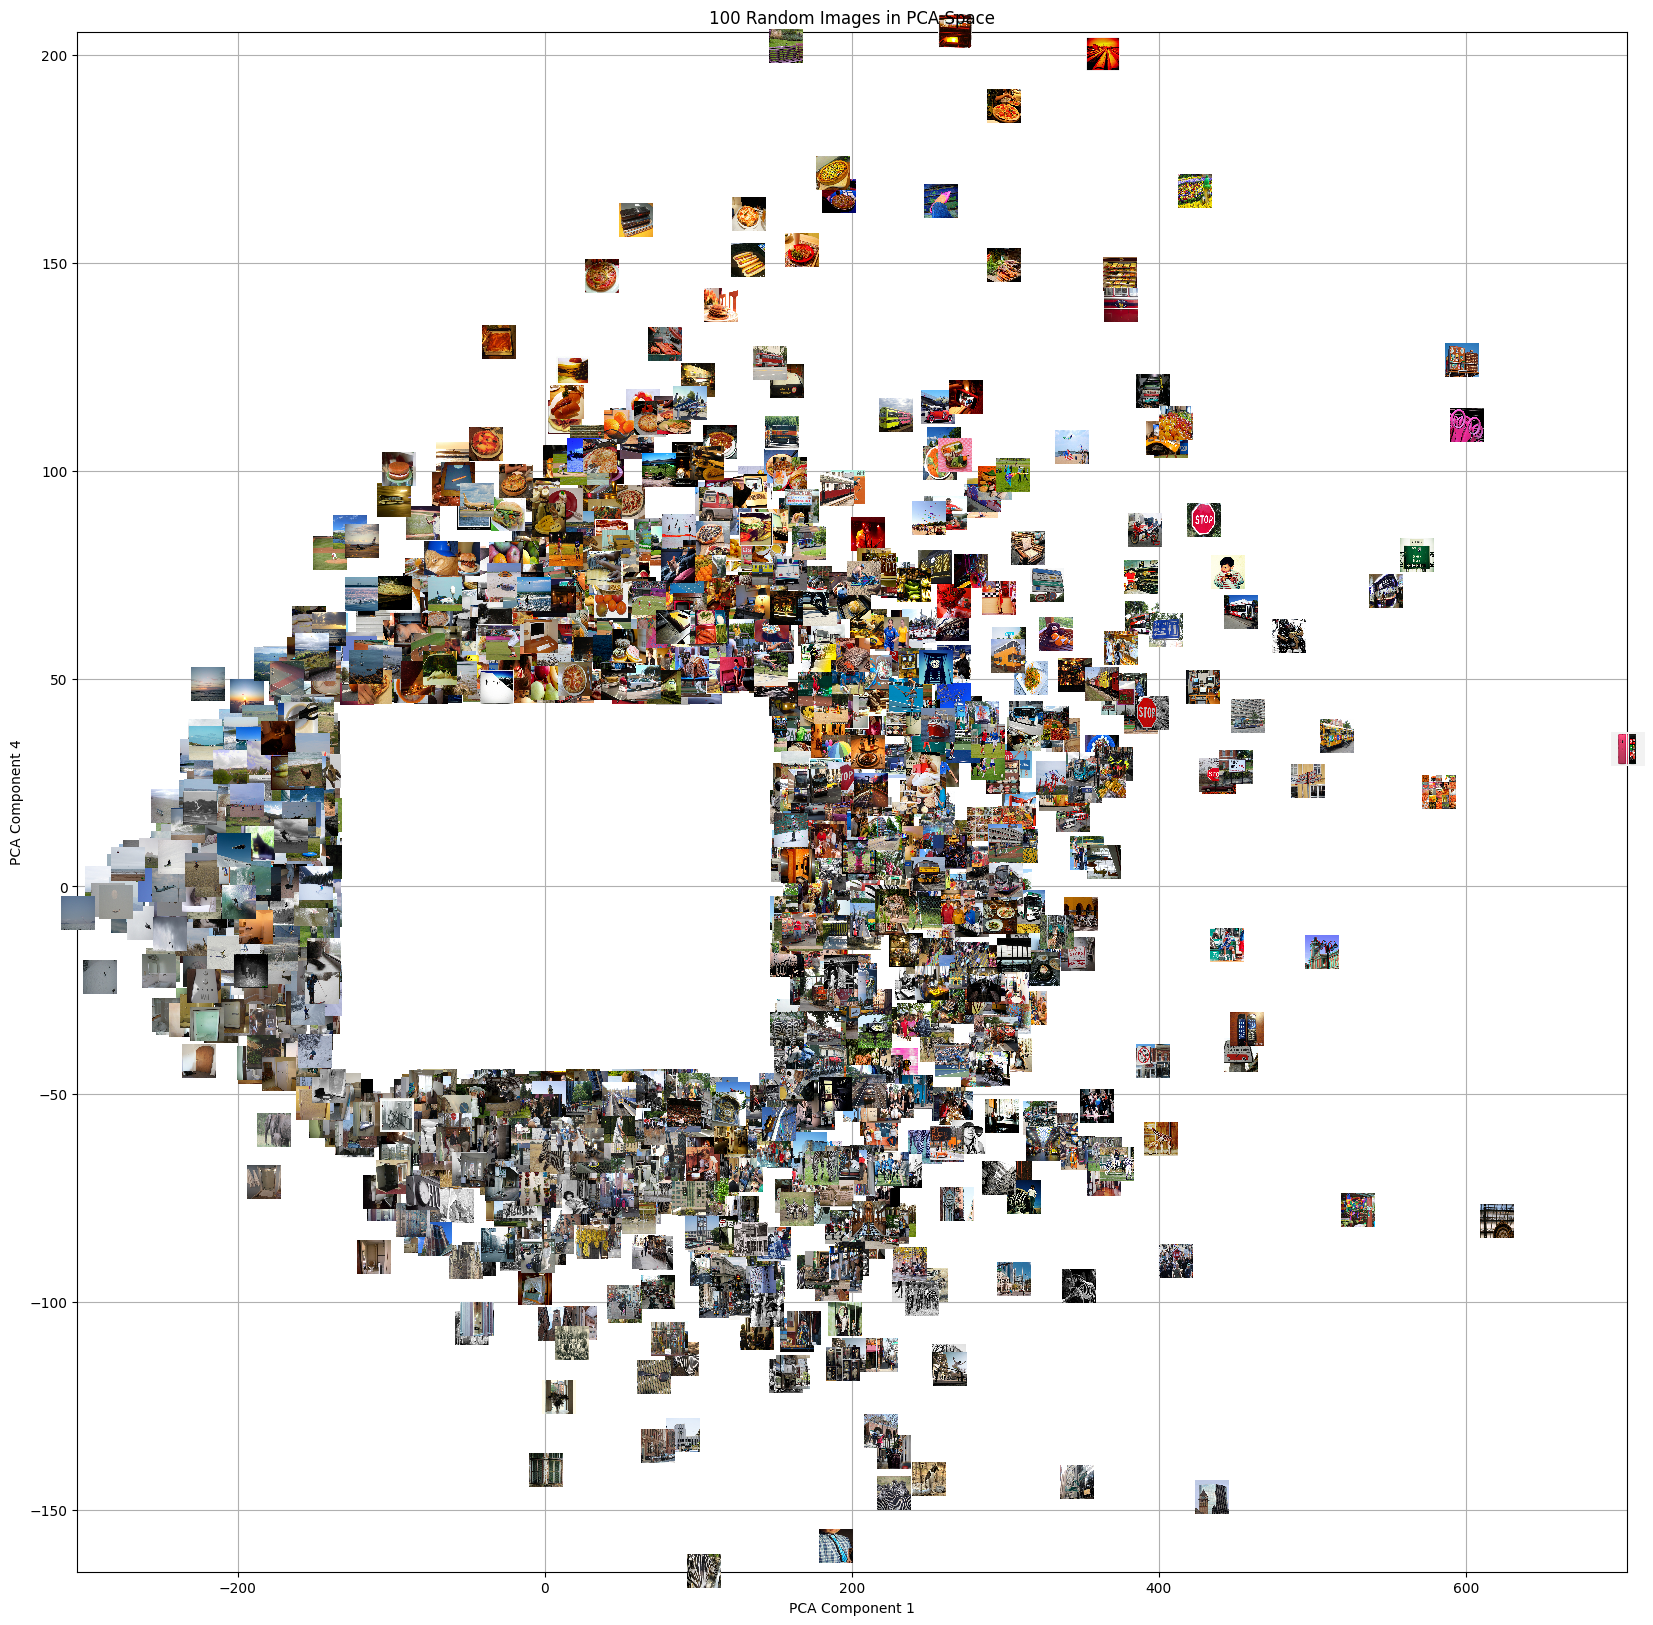

In [32]:
target_pcs = [0, 3]

cutoff = 10
percentile_top_pc1 = np.percentile(gram_pca[:, target_pcs[0]], cutoff)
percentile_bottom_pc1 = np.percentile(gram_pca[:, target_pcs[0]], 100- cutoff)
percentile_top_pc2 = np.percentile(gram_pca[:, target_pcs[1]], cutoff)
percentile_bottom_pc2 = np.percentile(gram_pca[:, target_pcs[1]], 100- cutoff)

indices = [
    i for i, point in enumerate(gram_pca)
    if (point[target_pcs[0]] <= percentile_top_pc1 or point[target_pcs[0]] >= percentile_bottom_pc1) or
       (point[target_pcs[1]] <= percentile_top_pc2 or point[target_pcs[1]] >= percentile_bottom_pc2)
]

plt.figure(figsize=(20, 20), dpi=100)
ax = plt.gca()

for idx in indices:
    x, y = gram_pca[idx, target_pcs[0]], gram_pca[idx, target_pcs[1]]
    img = Image.open(dataset.paths[idx]).convert('RGB')
    img = img.resize((128*2, 128*2), Image.LANCZOS)  # Resize to higher resolution
    img_np = np.asarray(img)
    imagebox = OffsetImage(img_np, zoom=24/(128*2))  # Display at 24x24 size, but with higher resolution
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.0)
    ax.add_artist(ab)

# Optionally set axis limits to focus on the data
ax.set_xlim(gram_pca[:, target_pcs[0]].min(), gram_pca[:, target_pcs[0]].max())
ax.set_ylim(gram_pca[:, target_pcs[1]].min(), gram_pca[:, target_pcs[1]].max())

plt.xlabel(f'PCA Component {target_pcs[0] + 1}')
plt.ylabel(f'PCA Component {target_pcs[1] + 1}')
plt.title('100 Random Images in PCA Space')
plt.grid(True)
plt.show()